In [48]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Загружаем данные
df = pd.read_csv("data/merged_freight_oil.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Берём только числовые признаки
data = df[["Freight_Price", "Oil_Price"]].values.astype(np.float32)

# Масштабируем
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [49]:
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:i+seq_len]
        y = data[i+seq_len, 0]  # только Freight_Price
        xs.append(x)
        ys.append(y)
    return torch.tensor(xs), torch.tensor(ys)

seq_len = 12
X, y = create_sequences(data_scaled, seq_len)

# Последние 48 месяцев оставим для прогноза
X_train, y_train = X[:-48], y[:-48]
X_test_start = data_scaled[-(48 + seq_len):]

In [50]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size=2, hidden_size=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1]).squeeze()
    
model = LSTMForecast()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [51]:
# # Обучение
# for epoch in range(50):
#     model.train()
#     optimizer.zero_grad()
#     output = model(X_train)
#     loss = loss_fn(output, y_train)
#     loss.backward()
#     optimizer.step()
#     if epoch % 10 == 0:
#         print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")

In [52]:
# Обучение
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()

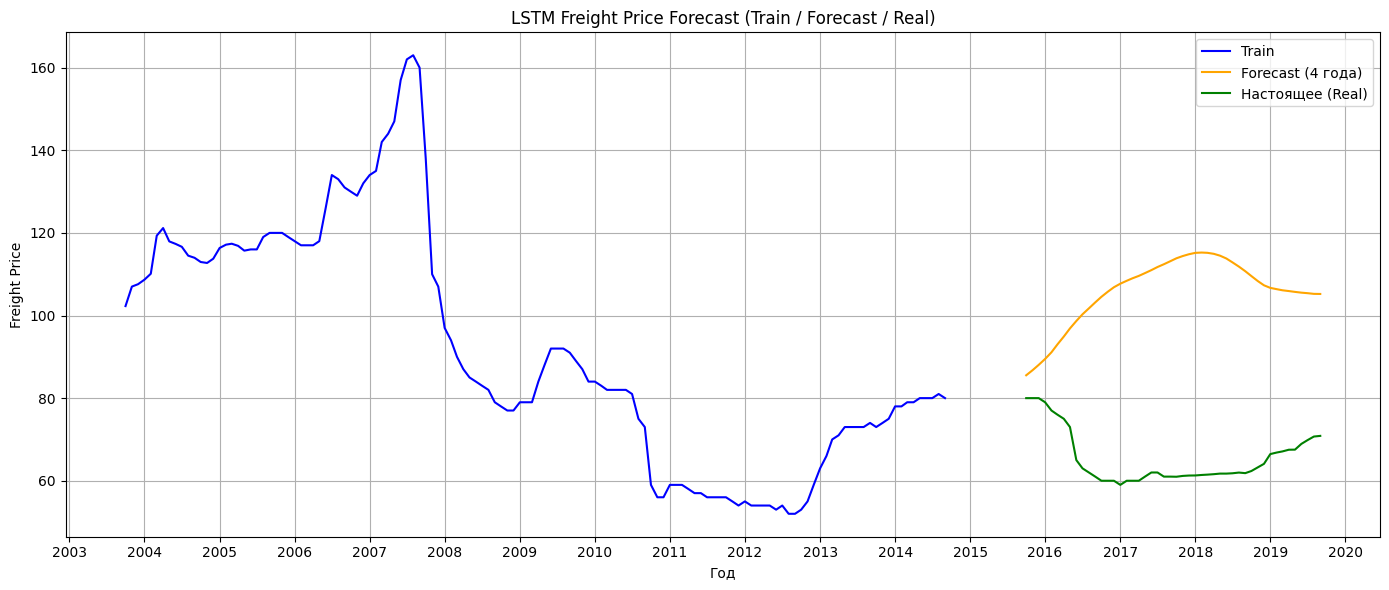

In [55]:
model.eval()
input_seq = torch.tensor(X_test_start[:seq_len]).unsqueeze(0)
predictions = []

with torch.no_grad():
    for i in range(48):
        pred = model(input_seq).item()
        oil_next = X_test_start[seq_len + i, 1]
        new_entry = torch.tensor([[pred, oil_next]])
        input_seq = torch.cat([input_seq[:, 1:], new_entry.unsqueeze(0)], dim=1)
        predictions.append(pred)

# Инверсия нормализации
pred_arr = np.array(predictions).reshape(-1, 1)
oil_vals = X_test_start[seq_len:, 1].reshape(-1, 1)
combined_pred = np.hstack((pred_arr, oil_vals))
forecast_prices = scaler.inverse_transform(combined_pred)[:, 0]
true_prices = data[-48:, 0]

# Подготовка дат
forecast_dates = df["Date"].iloc[-48:].values
train_dates = df["Date"].iloc[:len(y_train)].values
test_dates = df["Date"].iloc[-48:].values

# Инверсия train
train_combined = np.hstack((y_train.numpy().reshape(-1, 1), X_train[:, -1, 1].unsqueeze(1).numpy()))
train_pred_prices = scaler.inverse_transform(train_combined)[:, 0]

# Построение графика
plt.figure(figsize=(14, 6))
plt.plot(train_dates, train_pred_prices, label="Train", color="blue")
plt.plot(test_dates, forecast_prices, label="Forecast (4 года)", color="orange")
plt.plot(test_dates, true_prices, label="Настоящее (Real)", color="green")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel("Год")
plt.ylabel("Freight Price")
plt.title("LSTM Freight Price Forecast (Train / Forecast / Real)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

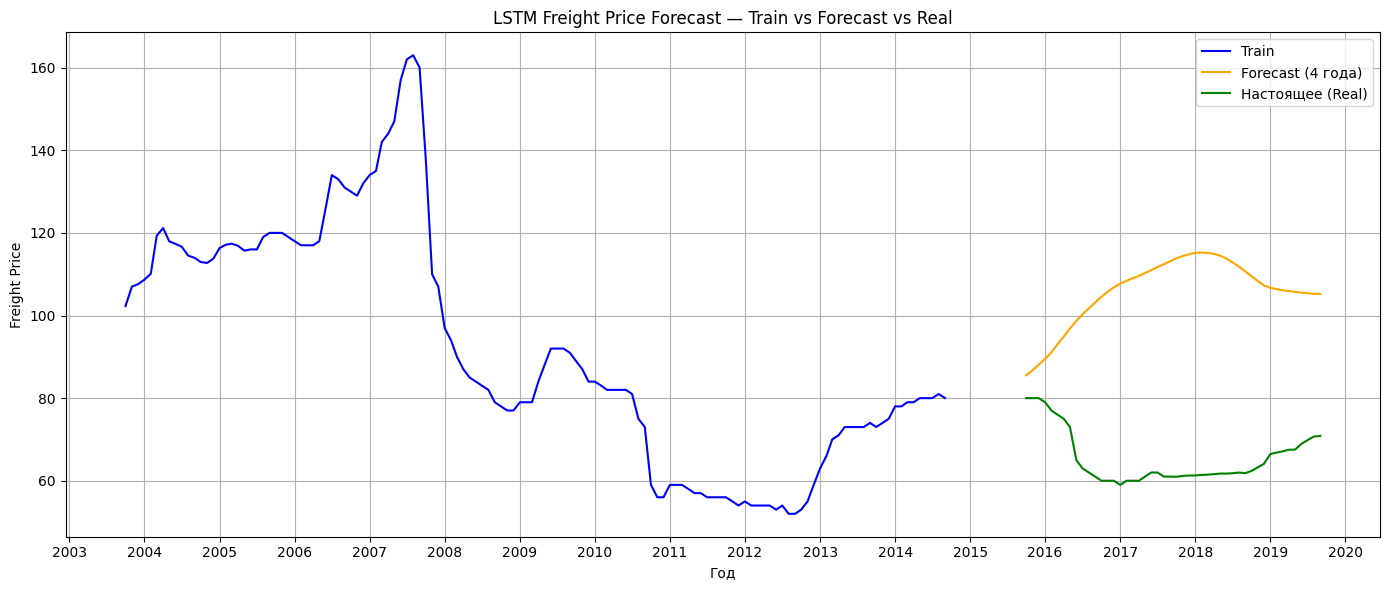

In [54]:
import matplotlib.dates as mdates

# Подготовка дат
forecast_dates = df["Date"].iloc[-48:].values
train_dates = df["Date"].iloc[:len(y_train)].values
test_dates = df["Date"].iloc[-48:].values

# Инвертируем y_train в оригинальные значения
train_combined = np.hstack((
    y_train.numpy().reshape(-1, 1),
    X_train[:, -1, 1].unsqueeze(1).numpy()  # последний Oil_Price
))
train_pred_prices = scaler.inverse_transform(train_combined)[:, 0]

# Построение графика
plt.figure(figsize=(14, 6))

# 🔵 Train
plt.plot(train_dates, train_pred_prices, label="Train", color="blue")

# 🟠 Forecast
plt.plot(test_dates, forecast_prices, label="Forecast (4 года)", color="orange")

# 🟢 Реальные значения
plt.plot(test_dates, true_prices, label="Настоящее (Real)", color="green")

# 📅 Оформление времени по Ox
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel("Год")
plt.ylabel("Freight Price")
plt.title("LSTM Freight Price Forecast — Train vs Forecast vs Real")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()